In [131]:
import author
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import Ridge,Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
engine = author.raw_engine

In [132]:
df = pd.read_sql("SELECT * FROM BTCUSD_1d",engine)
df.set_index('Date',inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-11-30,7764.057129,7836.102051,7515.849609,7569.629883,7569.629883,17158194786
2019-12-01,7571.616211,7571.616211,7291.341797,7424.292480,7424.292480,18720708479
2019-12-02,7424.036133,7474.818848,7233.399414,7321.988281,7321.988281,17082040706
2019-12-03,7323.975586,7418.858887,7229.356934,7320.145508,7320.145508,14797485769
2019-12-04,7320.125000,7539.784668,7170.922852,7252.034668,7252.034668,21664240918
...,...,...,...,...,...,...
2022-02-24,37278.566406,38968.839844,34459.218750,38332.609375,38332.609375,46383802093
2022-02-25,38333.746094,39630.324219,38111.343750,39214.218750,39214.218750,26545599159
2022-02-26,39213.082031,40005.347656,38702.535156,39105.148438,39105.148438,17467554129


<AxesSubplot:>

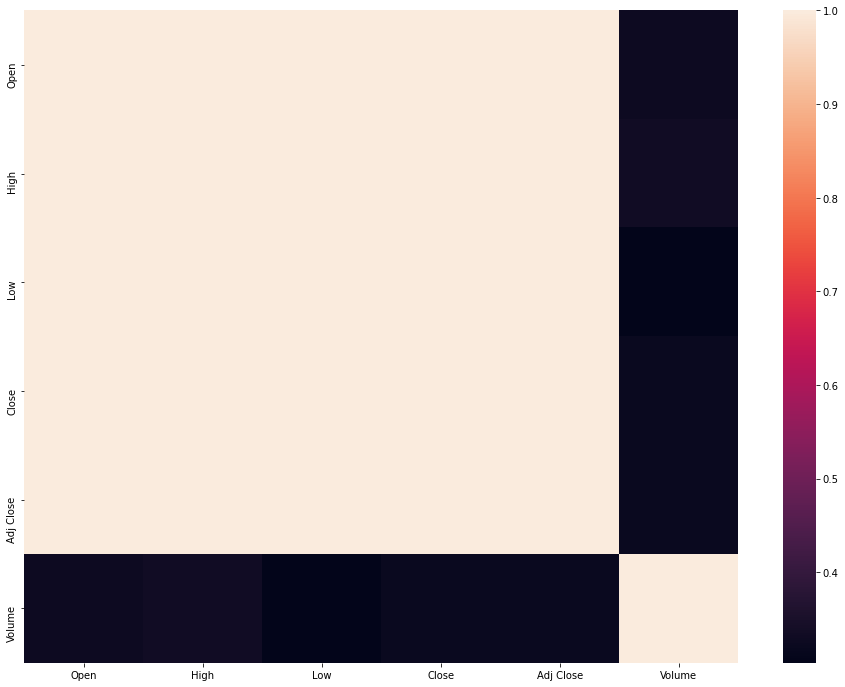

In [133]:
plt.figure(figsize=(16,12))
sns.heatmap(df.corr())

o,h,l,c는 실상 동일하므로 피쳐를 조합해 새로운 피쳐를 만들어준다.

In [134]:
gap = (df['High'] - df['Low'])
df['Gap'] = df['Gap'] / df['Low']

df['Gap'] = gap
df

,Open,High,Low,Close,Adj Close,Volume,Gap
Date,,,,,,,
2019-11-30,7764.057129,7836.102051,7515.849609,7569.629883,7569.629883,17158194786,320.252441
2019-12-01,7571.616211,7571.616211,7291.341797,7424.292480,7424.292480,18720708479,280.274414
2019-12-02,7424.036133,7474.818848,7233.399414,7321.988281,7321.988281,17082040706,241.419434
2019-12-03,7323.975586,7418.858887,7229.356934,7320.145508,7320.145508,14797485769,189.501953
2019-12-04,7320.125000,7539.784668,7170.922852,7252.034668,7252.034668,21664240918,368.861816
...,...,...,...,...,...,...,...
2022-02-24,37278.566406,38968.839844,34459.218750,38332.609375,38332.609375,46383802093,4509.621094
2022-02-25,38333.746094,39630.324219,38111.343750,39214.218750,39214.218750,26545599159,1518.980469
2022-02-26,39213.082031,40005.347656,38702.535156,39105.148438,39105.148438,17467554129,1302.812500


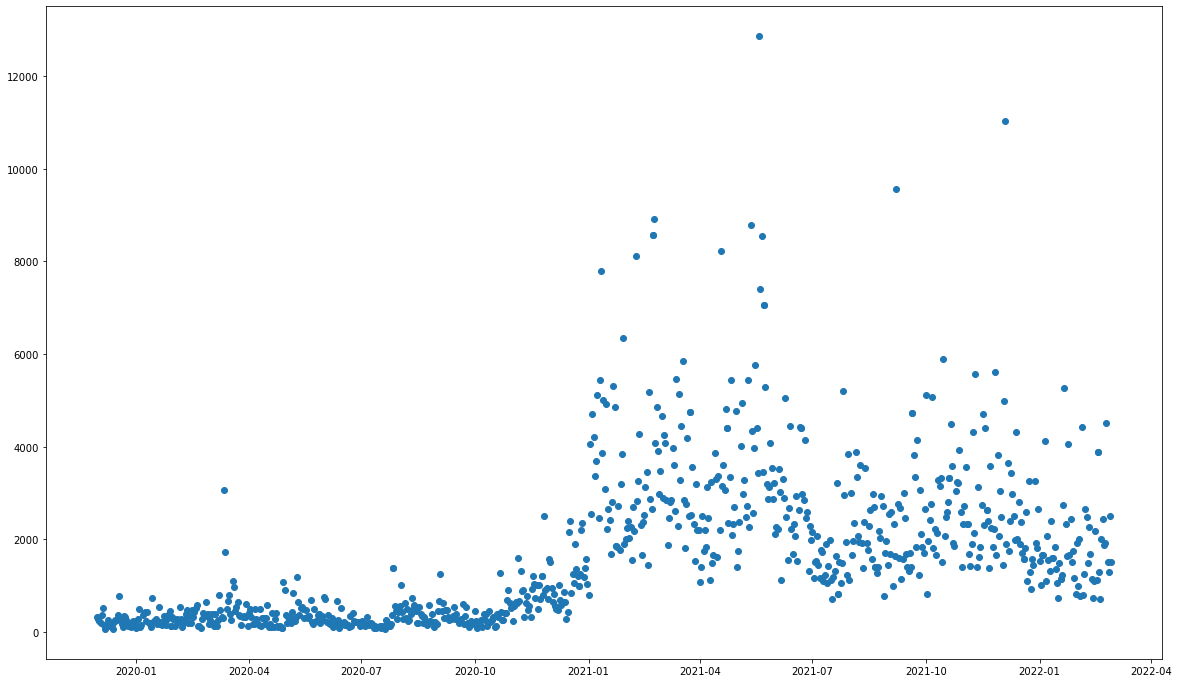

In [135]:
plt.figure(figsize=(20,12))
plt.scatter(df['Gap'].index, df['Gap'])

값이 커짐에 따라 변동폭도 증가하므로 명확한 아웃라이어를 보기위해 비트코인의 가격 상승을 반영해준다.

In [136]:
df['Gap'] = df['Gap'] / df['Low']

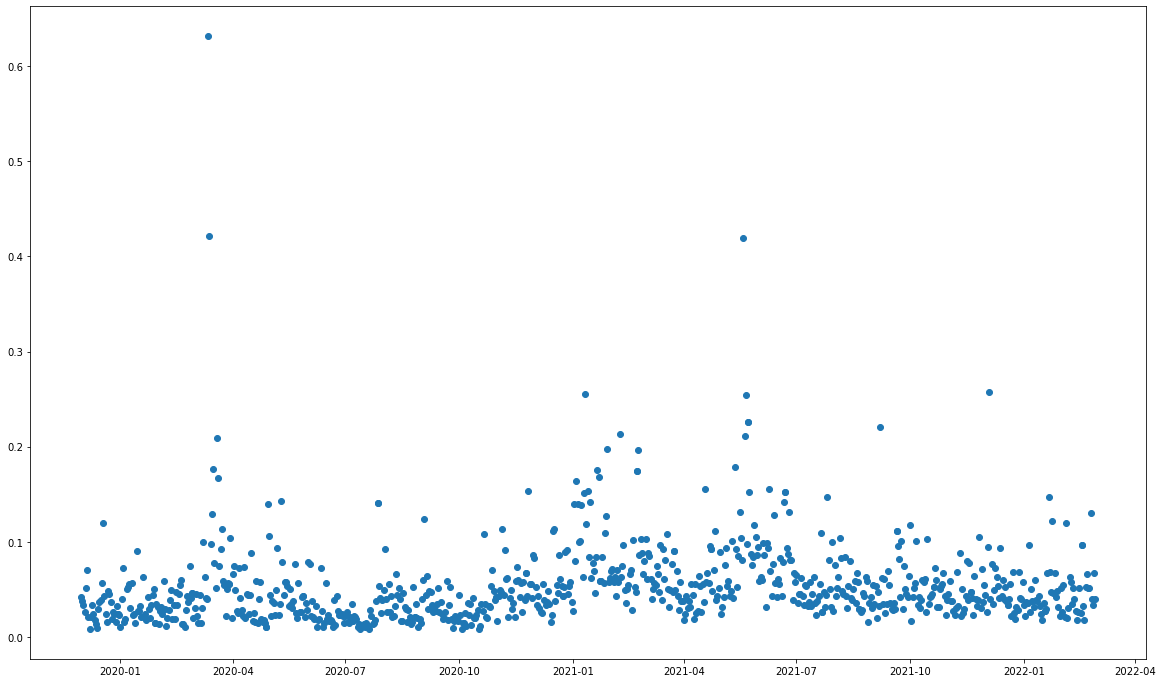

In [137]:
plt.figure(figsize=(20,12))
plt.scatter(df['Gap'].index, df['Gap'])

In [138]:
def get_macd(df):
    price = df['Adj Close']
    exp12 = price.ewm(span = 12, adjust=False).mean()
    exp26 = price.ewm(span = 26, adjust=False).mean()
    macd = exp12 - exp26
    exp = macd.ewm(span=9,adjust=False).mean()
    return exp

def get_rsi(df, period):
    close_price = df['Close']
    delta = close_price.diff()
    gains,drops = delta.copy(),delta.copy()
    gains[gains < 0] = 0
    drops[drops > 0] = 0
    au = gains.ewm(com=period-1, min_periods=period).mean()
    ad = drops.abs().ewm(com=period-1, min_periods=period).mean()
    rs = au / ad
    rsi = pd.Series(100 - (100 / (1 + rs)))
    return rsi

def get_vwap(df):
    volumes = df['Volume']
    price = df['Adj Close']
    vwap = ((volumes * price).cumsum()) / volumes.cumsum()
    return vwap

In [139]:
df['VWAP'] = get_vwap(df)
df['RSI'] = get_rsi(df,7)
df['MACD'] = get_macd(df)
df['Gap'] = (df['High'] - df['Low']) / df['Low']

df

,Open,High,Low,Close,Adj Close,Volume,Gap,VWAP,RSI,MACD
Date,,,,,,,,,,
2019-11-30,7764.057129,7836.102051,7515.849609,7569.629883,7569.629883,17158194786,0.042610,7569.629883,NaN,0.000000
2019-12-01,7571.616211,7571.616211,7291.341797,7424.292480,7424.292480,18720708479,0.038439,7493.796485,NaN,-2.318773
2019-12-02,7424.036133,7474.818848,7233.399414,7321.988281,7321.988281,17082040706,0.033376,7438.381409,NaN,-7.596274
2019-12-03,7323.975586,7418.858887,7229.356934,7320.145508,7320.145508,14797485769,0.026213,7412.560355,NaN,-14.463679
2019-12-04,7320.125000,7539.784668,7170.922852,7252.034668,7252.034668,21664240918,0.051439,7373.670137,NaN,-23.021307
...,...,...,...,...,...,...,...,...,...,...
2022-02-24,37278.566406,38968.839844,34459.218750,38332.609375,38332.609375,46383802093,0.130868,32471.703882,40.040442,-345.278918
2022-02-25,38333.746094,39630.324219,38111.343750,39214.218750,39214.218750,26545599159,0.039856,32477.196559,47.553642,-437.395225
2022-02-26,39213.082031,40005.347656,38702.535156,39105.148438,39105.148438,17467554129,0.033662,32480.747539,46.708864,-504.103075


In [140]:
df = df.dropna()
df = df.drop(['Open','Close','High','Low','Volume'], axis=1)
df


,Adj Close,Gap,VWAP,RSI,MACD
Date,,,,,
2019-12-07,7556.237793,0.008536,7425.601379,61.524887,-31.259078
2019-12-08,7564.345215,0.021203,7439.201502,62.443081,-29.284828
2019-12-09,7400.899414,0.034226,7435.291627,39.994376,-28.820488
2019-12-10,7278.119629,0.024562,7420.455488,30.412359,-31.220062
2019-12-11,7217.427246,0.017876,7404.623554,26.720413,-36.186049
...,...,...,...,...,...
2022-02-24,38332.609375,0.130868,32471.703882,40.040442,-345.278918
2022-02-25,39214.218750,0.039856,32477.196559,47.553642,-437.395225
2022-02-26,39105.148438,0.033662,32480.747539,46.708864,-504.103075


<AxesSubplot:>

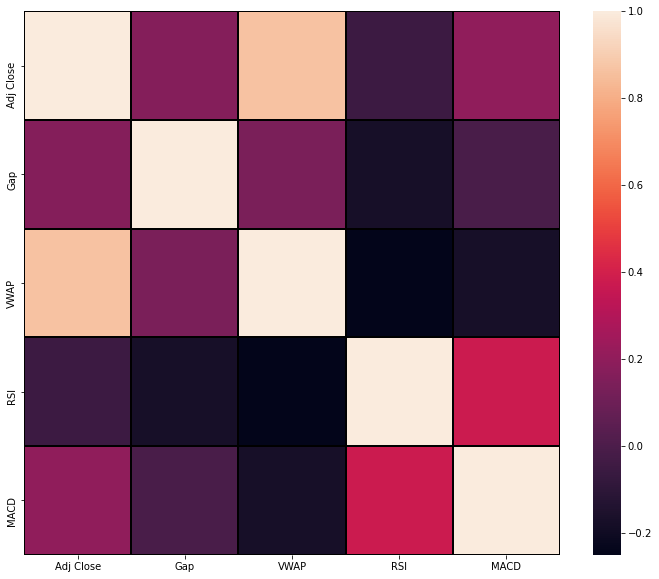

In [141]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),linewidth=1,linecolor='black')

vwap와 rsi가 음의 상관관계를 띄는 것을 확인할 수 있다. 또한 gap은 volume과 양의 상관 관계를 띄는데 이로써 거래량이 튀면 고점이 증가한다는 것을 확인할 수 있다.

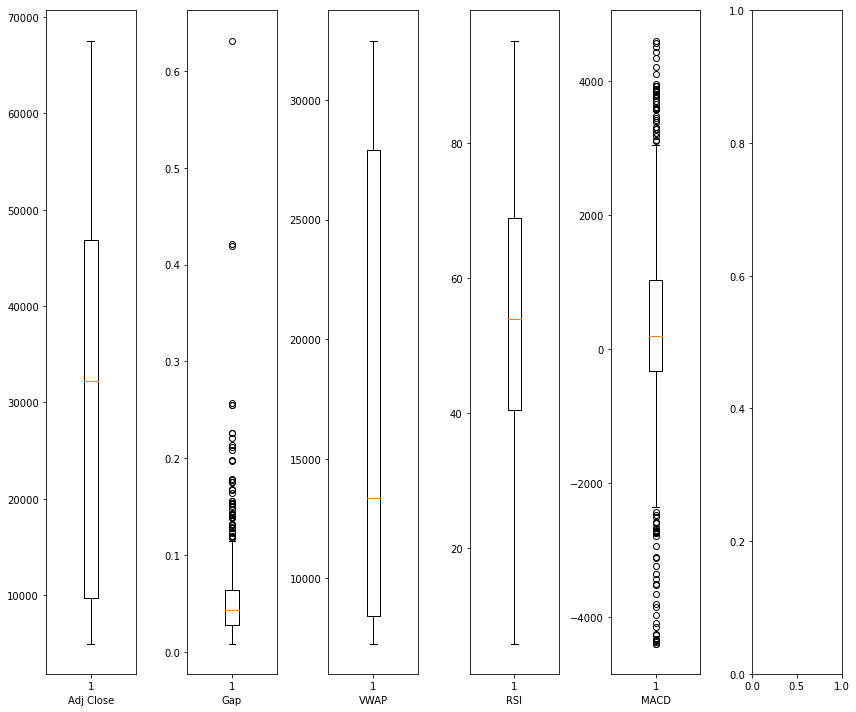

In [142]:
fig,axes = plt.subplots(1,6,figsize=(12,10))
for i, c in enumerate(df.columns,start=1):
    plt.subplot(1,6,i)
    plt.boxplot(df[c])
    plt.xlabel(c)
plt.tight_layout()

iqr 범위를 벗어나는 데이터가 몇개 있는지 확인해보자. gap, vwap, macd가 특히 심하다.


In [ ]:
from collections import defaultdict
def remove_outliers(df):
    q_1 = df.apply(lambda x: np.quantile(x,0.25))
    q_3 = df.apply(lambda x: np.quantile(x,0.75))
    iqr = q_3 - q_1
    min_p = q_1 - 2.0 * iqr
    max_p = q_3 + 2.0 * iqr
    outliers = np.where((df < min_p) | (df > max_p))
    row,col = outliers
    df = df.drop(df.index[row])
    return df



In [143]:
q_1 = df.apply(lambda x: np.quantile(x,0.25))
q_3 = df.apply(lambda x: np.quantile(x,0.75))
iqr = q_3 - q_1
min_p = q_1 - 2.0 * iqr
max_p = q_3 + 2.0 * iqr
print(min_p,max_p)

Adj Close   -64661.732178
Gap             -0.043525
VWAP        -30592.432401
RSI            -16.302811
MACD         -3039.736975
dtype: float64 Adj Close    121173.430176
Gap               0.134567
VWAP          66897.724237
RSI             125.678558
MACD           3739.787604
dtype: float64


In [144]:
outliers = np.where((df < min_p) | (df > max_p))
outliers

(array([ 99, 100, 103, 106, 107, 149, 160, 240, 241, 367, 405, 407, 408,
        411, 413, 413, 414, 414, 415, 416, 416, 417, 418, 418, 424, 425,
        433, 443, 454, 455, 456, 457, 457, 458, 458, 459, 459, 460, 461,
        462, 514, 539, 546, 547, 548, 549, 550, 550, 551, 551, 552, 552,
        553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565,
        566, 567, 568, 568, 569, 580, 581, 582, 617, 661, 706, 707, 708,
        709, 710, 711, 752, 802]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 4, 1, 4, 4,
        1, 4, 1, 1, 1, 1, 4, 4, 4, 1, 4, 1, 4, 1, 4, 4, 4, 4, 1, 1, 1, 1,
        1, 4, 1, 4, 1, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 1, 4, 4, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 1, 1]))

In [145]:
from collections import defaultdict
row,col = outliers
outliers_cols = defaultdict(list)
for r,c in zip(row,col):
    outliers_cols[df.columns[c]].append(r)
outliers_cols

defaultdict(list,
            {'Gap': [99,
              100,
              103,
              106,
              107,
              149,
              160,
              240,
              241,
              367,
              405,
              407,
              408,
              411,
              413,
              414,
              416,
              418,
              424,
              425,
              433,
              443,
              457,
              458,
              459,
              514,
              539,
              546,
              547,
              548,
              550,
              551,
              552,
              568,
              580,
              581,
              582,
              617,
              661,
              752,
              802],
             'MACD': [413,
              414,
              415,
              416,
              417,
              418,
              454,
              455,
              456,
              457

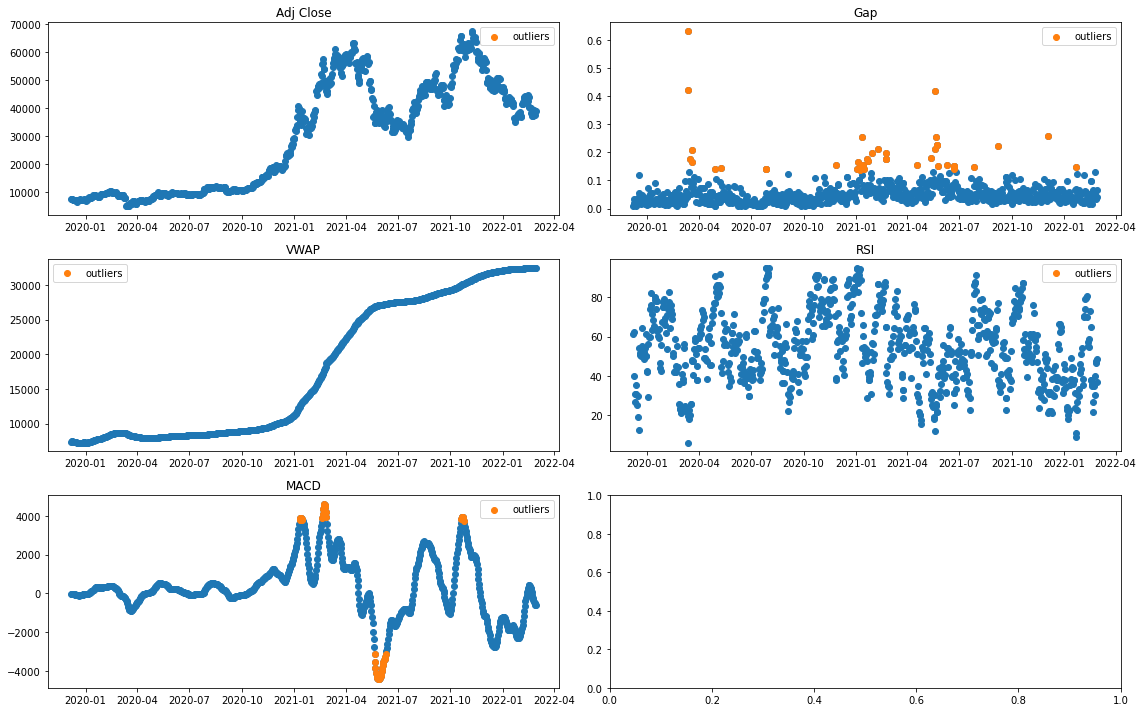

In [146]:
fig,axes = plt.subplots(3,2,figsize=(16,10))
for i, c in enumerate(df.columns,start=1):
    index = df[c].index
    plt.subplot(3,2,i)
    plt.title(c)
    plt.scatter(x=index,y=df[c])
    plt.scatter(x=df[c].iloc[outliers_cols[c]].index, y=df[c].iloc[outliers_cols[c]],label='outliers')
    plt.legend()
plt.tight_layout()

In [147]:
row

array([ 99, 100, 103, 106, 107, 149, 160, 240, 241, 367, 405, 407, 408,
       411, 413, 413, 414, 414, 415, 416, 416, 417, 418, 418, 424, 425,
       433, 443, 454, 455, 456, 457, 457, 458, 458, 459, 459, 460, 461,
       462, 514, 539, 546, 547, 548, 549, 550, 550, 551, 551, 552, 552,
       553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565,
       566, 567, 568, 568, 569, 580, 581, 582, 617, 661, 706, 707, 708,
       709, 710, 711, 752, 802])

아웃라이어를 제거해준다.

In [148]:
df = df.drop(df.index[row])
df

,Adj Close,Gap,VWAP,RSI,MACD
Date,,,,,
2019-12-07,7556.237793,0.008536,7425.601379,61.524887,-31.259078
2019-12-08,7564.345215,0.021203,7439.201502,62.443081,-29.284828
2019-12-09,7400.899414,0.034226,7435.291627,39.994376,-28.820488
2019-12-10,7278.119629,0.024562,7420.455488,30.412359,-31.220062
2019-12-11,7217.427246,0.017876,7404.623554,26.720413,-36.186049
...,...,...,...,...,...
2022-02-24,38332.609375,0.130868,32471.703882,40.040442,-345.278918
2022-02-25,39214.218750,0.039856,32477.196559,47.553642,-437.395225
2022-02-26,39105.148438,0.033662,32480.747539,46.708864,-504.103075


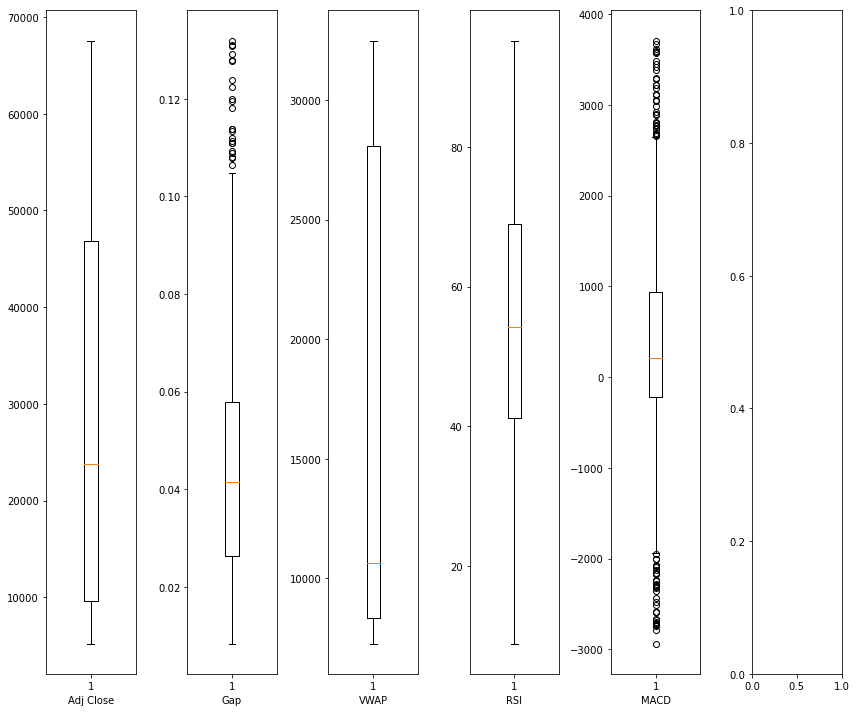

In [149]:
fig,axes = plt.subplots(1,6,figsize=(12,10))
for i, c in enumerate(df.columns,start=1):
    plt.subplot(1,6,i)
    plt.boxplot(df[c])
    plt.xlabel(c)
plt.tight_layout()

아웃라이어들이 제거된 것을 확인할 수 있다.

모델을 생성하고 비교해보자.

In [150]:
ridge_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=4, include_bias=True)),
    ('std_scaler', StandardScaler()),
    ('regulator', Ridge(alpha=10,solver="cholesky",random_state=42))
])
lasso_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=4, include_bias=True)),
    ('std_scaler', StandardScaler()),
    ('regulator', Lasso(alpha=10,random_state=42,fit_intercept=True))
])
rf_model = Pipeline([
    ('std_scaler', StandardScaler()),
    ('machine',RandomForestRegressor(bootstrap=True, random_state=42, oob_score=True))
])

In [151]:
def create_train_data(df):
    X = df.drop(['Adj Close'],axis=1)
    y = df['Adj Close'] #비트코인의 봉 평균가.
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=24)
    return train_X, test_X, train_y, test_y

In [152]:
train_X, test_X, train_y, test_y = create_train_data(df)
# ridge_model.fit(train_X, train_y)
# lasso_model.fit(train_X, train_y)

In [153]:
def find_best_alpha(train_X, train_y, test_X, test_y, model):
    best_alpha = 1
    best_mse = float('inf')
    for i in [1000,300,100,30,10,1]:
        model.set_params(regulator__alpha=i)
        model.fit(train_X, train_y)
        pred = model.predict(test_X)
        mse = ((test_y - pred) ** 2).mean()
        if best_mse > mse:
            best_mse = mse
            best_alpha = i
        print(f'mse: {mse}, alpha: {i}')
    return best_alpha
    
r_alpha = find_best_alpha(train_X, train_y, test_X, test_y, ridge_model)
ridge_model.set_params(regulator__alpha=r_alpha)
ridge_model.fit(train_X, train_y)

l_alpha = find_best_alpha(train_X, train_y, test_X, test_y, lasso_model)
lasso_model.set_params(regulator__alpha=l_alpha)
lasso_model.fit(train_X, train_y)



mse: 64246917.70283106, alpha: 1000
mse: 46582628.810443886, alpha: 300
mse: 35754198.62503462, alpha: 100
mse: 28041760.164219994, alpha: 30
mse: 25416362.67918576, alpha: 10
mse: 24705850.02450915, alpha: 1
mse: 36423490.305736266, alpha: 1000
mse: 28415104.220328517, alpha: 300
mse: 27315719.22434531, alpha: 100
mse: 25977095.45109768, alpha: 30
mse: 25203566.593940843, alpha: 10
mse: 24863826.08873998, alpha: 1


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52454838.01543045, tolerance: 20177964.093606725
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333392204.4561157, tolerance: 20177964.093606725
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5096707397.776152, tolerance: 20177964.093606725
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=4)),
                ('std_scaler', StandardScaler()),
                ('regulator', Lasso(alpha=1, random_state=42))])

In [154]:
def visualize(pred,target,name):
    plt.figure(figsize=(20,12))
    index = np.arange(len(target))
    plt.scatter(index, target,label='target')
    plt.scatter(index, pred,label='model')
    mse = np.mean((target - pred) ** 2)
    plt.suptitle(f'{name}',fontsize=20)
    plt.title(f'MSE is {mse:.1f}')
    plt.legend()

In [155]:
r_pred = ridge_model.predict(test_X)
l_pred = lasso_model.predict(test_X)

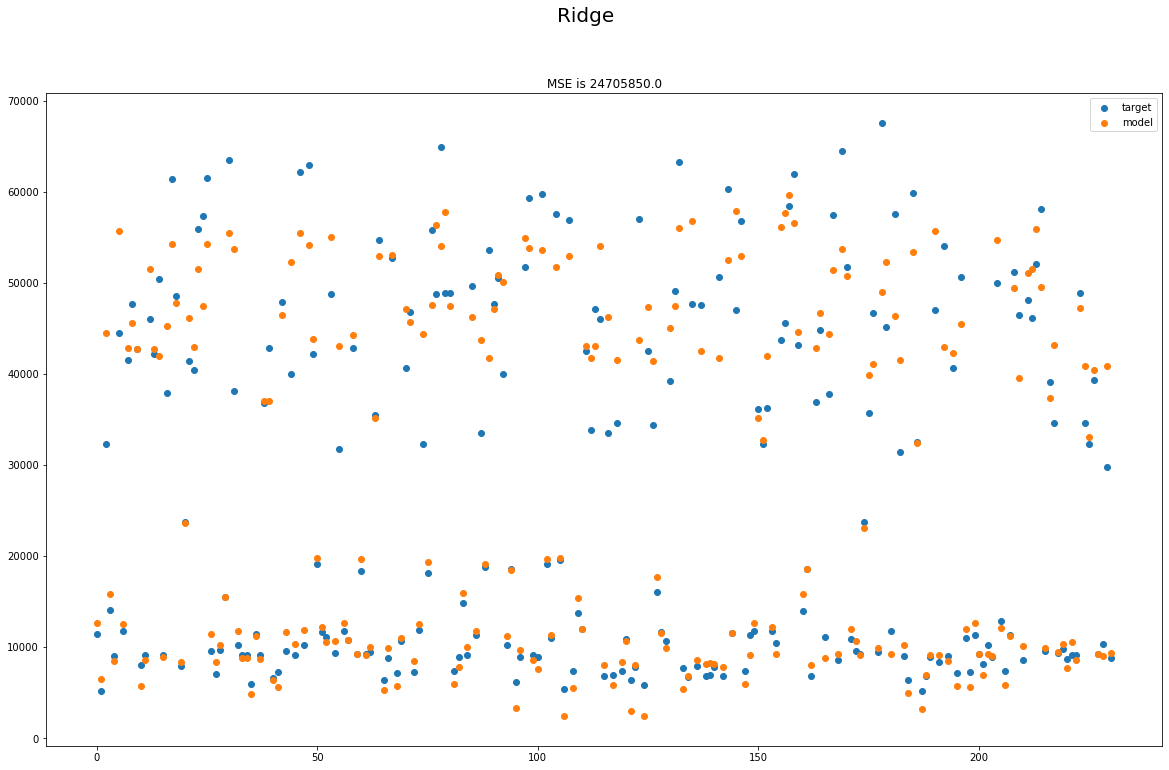

In [156]:
visualize(r_pred,test_y,"Ridge")

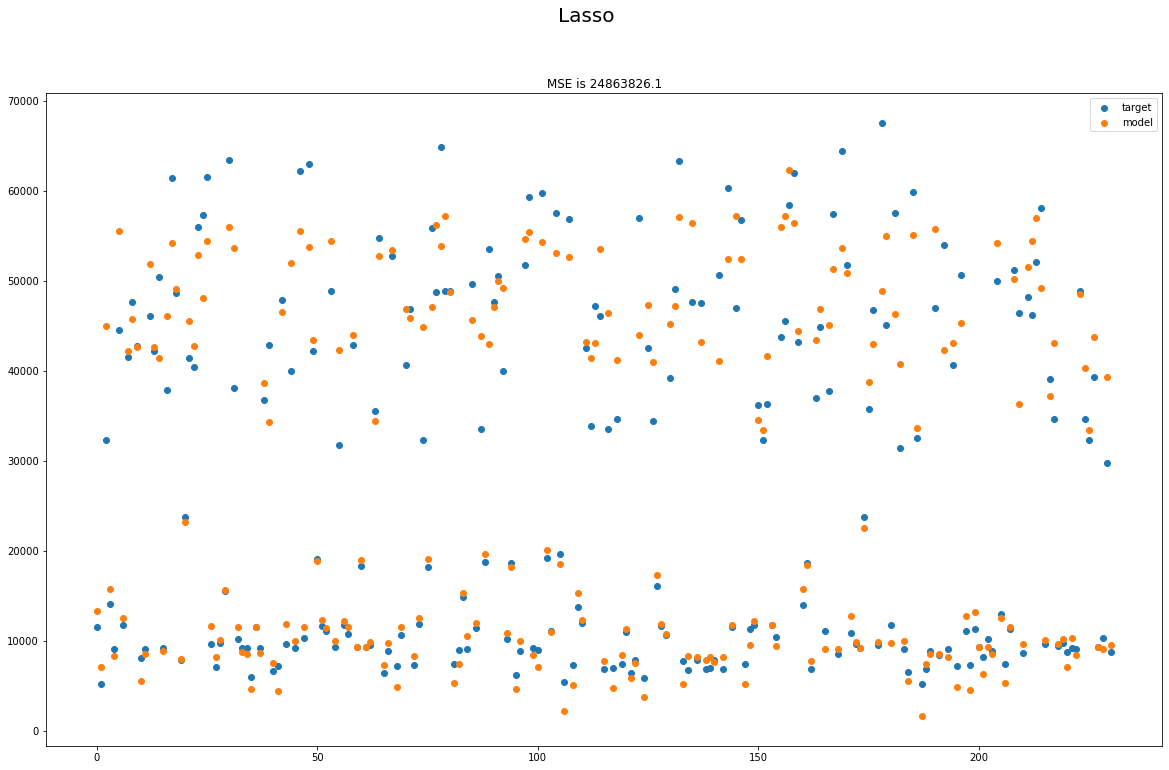

In [157]:
visualize(l_pred, test_y, "Lasso")

In [158]:
def visualize_plot(pred,target,name):
    pred = pd.Series(pred, index=target.index)
    plt.figure(figsize=(12,10))
    pred.sort_index().plot(label='model')
    test_y.sort_index().plot(label='target')
    plt.title(name)
    plt.legend()


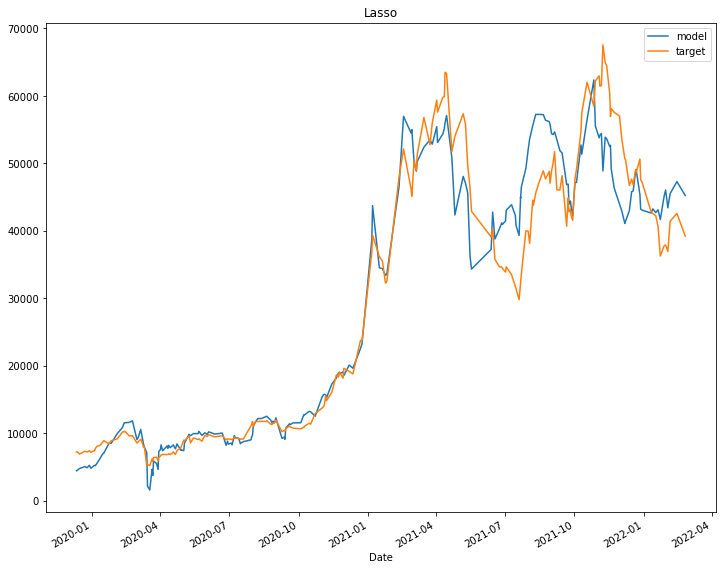

In [159]:
visualize_plot(l_pred, test_y, 'Lasso')

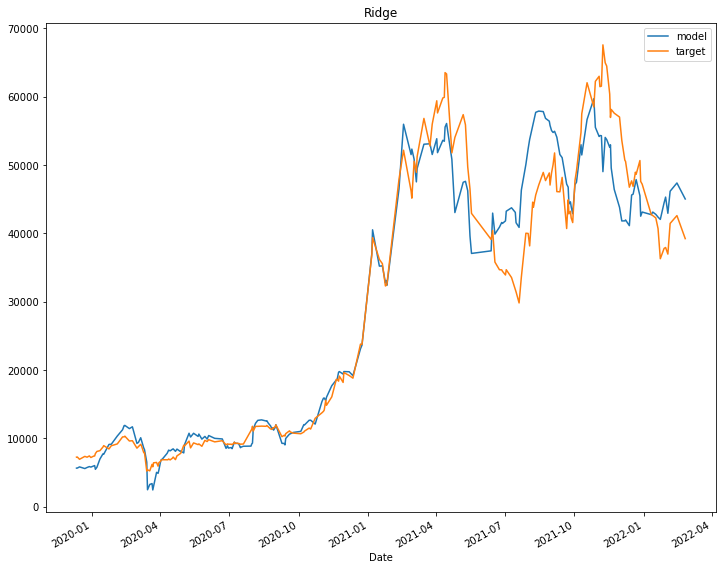

In [160]:
visualize_plot(r_pred, test_y, "Ridge")

릿지랑 라소는 예측률이 썩 좋지 못하다. 릿지와 라쏘를 사용하기엔 문제가 있을 듯 하다.

In [161]:
rf_model.fit(train_X, train_y)
rf_pred = rf_model.predict(test_X)

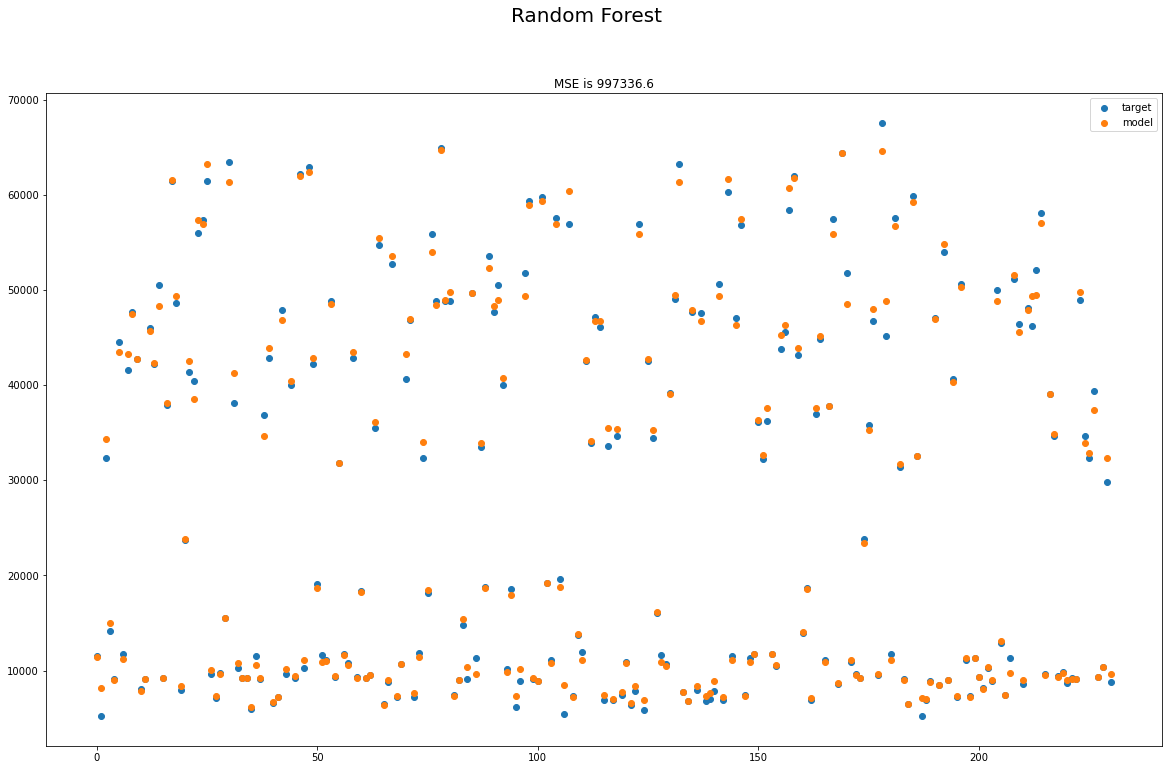

In [162]:
visualize(rf_pred, test_y, "Random Forest")

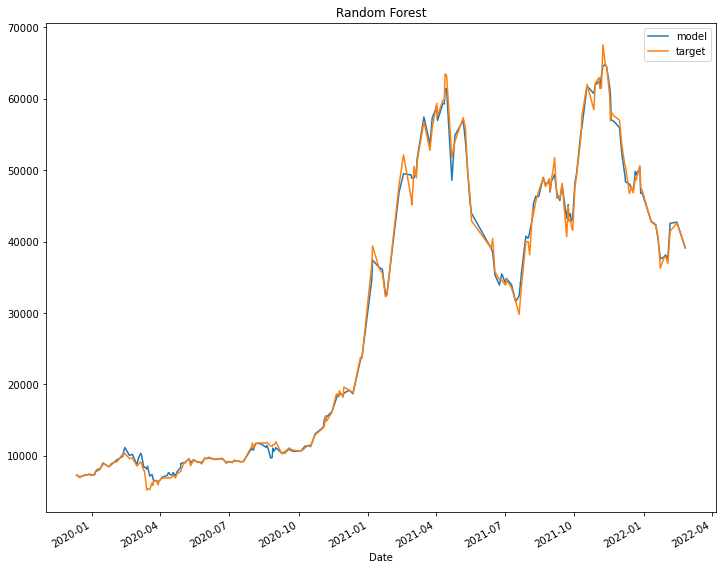

In [163]:
visualize_plot(rf_pred, test_y, "Random Forest")

In [164]:
from joblib import dump #모델을 저장한다.
dump(rf_model,'model/BTCUSD_RF_1d.joblib')


['model/BTCUSD_RF_1d.joblib']